<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [55]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from IPython.display import clear_output


%matplotlib inline

In [56]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [57]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [58]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [59]:
from sklearn.model_selection import train_test_split

# Загружаем лица
train_data, val_data = train_test_split(torch.tensor(np.rollaxis(data, 3, 1)).float(),test_size=0.2)

In [60]:
from torch.utils.data import Dataset, DataLoader

# Определим кастомный класс датасета, чтобы получать данные без лэйблов
class ImageDataset(Dataset):
    def __init__(self,data):
        self.data = data
        
    def __getitem__(self, index):
        x = self.data[index]
        return x
    
    def __len__(self):
        return len(self.data)

# Создадим лоадеры
train_dataset, val_dataset = ImageDataset(train_data), ImageDataset(val_data)

train_loader , val_loader = DataLoader(train_dataset,32,True), DataLoader(val_dataset,32,True)

Отрисуем несколько лиц, чтобы убедиться, что данные корректно загружены 

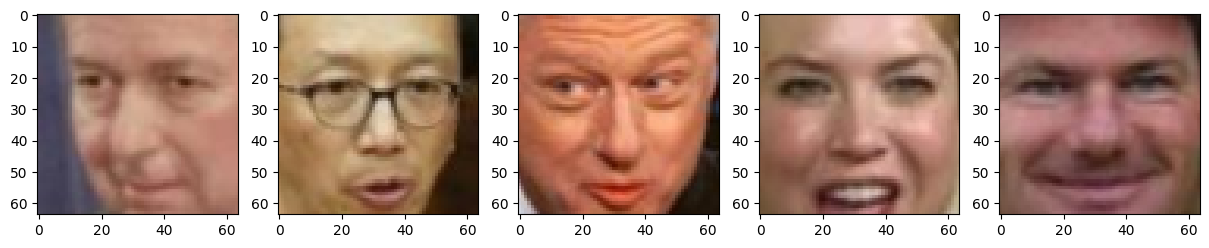

In [61]:
import random

fig = plt.figure(figsize=(15, 3))
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(data[random.randrange(0,len(data))])

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [62]:
dim_code = 512 # Размер латентного вектора
start_features = 32 # Количество карт активации на старте

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

Реализуем сверточный автоэнкодер 

In [63]:
class Autoencoder(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder>
        # Обратите внимание на формат, в котором функция fetch() возвращает data
        super(Autoencoder,self).__init__()

        # self.dim_code = dim_code
        self.encoder = nn.Sequential(
            nn.Conv2d(3, start_features, 3, padding=1),
            nn.BatchNorm2d(start_features),
            nn.MaxPool2d(2,2), # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(start_features, start_features * 2, 3, padding=1),
            nn.BatchNorm2d(start_features * 2),
            nn.MaxPool2d(2,2), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(start_features * 2, start_features * 4, 3, padding=1),
            nn.BatchNorm2d(start_features * 4),
            nn.MaxPool2d(2,2), # 16 -> 8
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(start_features * 4 * 8*8, dim_code)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, start_features * 4 * 8*8),
            nn.Unflatten(1,(start_features * 4,8,8)),
            # nn.ConvTranspose2d(start_features * 8, start_features * 4, 3, stride=2, padding=1, output_padding=1), # 4 -> 8
            # nn.BatchNorm2d(start_features * 4),
            # nn.LeakyReLU(),
            nn.ConvTranspose2d(start_features * 4, start_features * 2, 3, stride=2, padding=1, output_padding=1), # 8 -> 16
            nn.BatchNorm2d(start_features * 2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(start_features * 2, start_features, 3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.BatchNorm2d(start_features),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(start_features, 3, 3, stride=2, padding=1, output_padding=1), # 32 -> 64
            nn.Sigmoid()
        )
    def sample(self, z):
        generated = self.decoder(z)
        return generated

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [216]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder>
        # Обратите внимание на формат, в котором функция fetch() возвращает data
        super(Autoencoder,self).__init__()

        # self.dim_code = dim_code
        self.encoder = nn.Sequential(
            nn.Conv2d(3, start_features, 3, padding=1),
            nn.BatchNorm2d(start_features),
            nn.MaxPool2d(2,2), # 64 -> 32
            nn.LeakyReLU(),
            nn.Conv2d(start_features, start_features * 2, 3, padding=1),
            nn.BatchNorm2d(start_features * 2),
            nn.MaxPool2d(2,2), # 32 -> 16
            nn.LeakyReLU(),
            nn.Conv2d(start_features * 2, start_features * 4, 3, padding=1),
            nn.BatchNorm2d(start_features * 4),
            nn.MaxPool2d(2,2), # 16 -> 8
            nn.LeakyReLU(),
            nn.Conv2d(start_features * 4, start_features * 8, 3, padding=1),
            nn.BatchNorm2d(start_features * 8),
            nn.MaxPool2d(2,2), # 8 -> 4
            nn.LeakyReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(start_features * 8 * 4*4, dim_code)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, start_features * 8 * 4*4),
            nn.Unflatten(1,(start_features * 8,4,4)),
            nn.ConvTranspose2d(start_features * 8, start_features * 4, 3, stride=2, padding=1, output_padding=1), # 4 -> 8
            nn.BatchNorm2d(start_features * 4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(start_features * 4, start_features * 2, 3, stride=2, padding=1, output_padding=1), # 8 -> 16
            nn.BatchNorm2d(start_features * 2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(start_features * 2, start_features, 3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.BatchNorm2d(start_features),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(start_features, 3, 3, stride=2, padding=1, output_padding=1), # 32 -> 64
            nn.Sigmoid()
        )
    def sample(self, z):
        generated = self.decoder(z)
        return generated

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [64]:
import torch.utils


criterion = F.mse_loss

autoencoder = Autoencoder().to(device)

optimizer = optim.AdamW(autoencoder.parameters(),lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

### Вспомогательные функции

#### Функция обучения

In [65]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader, scheduler = None, visible = True):
    # Инициализация лоссов и метрик
    losses = {"train" : [], "val" : []}
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_pred, Y_latent = model(X_batch)
            loss =  loss_fn(X_batch,Y_pred)
            loss.backward()
            opt.step()
            opt.zero_grad()
            avg_loss += loss / len(train_loader)
            X_batch = X_batch.detach().cpu()
        losses["train"].append(avg_loss.detach().cpu())
        print('loss: %f' % avg_loss)
        
        # show intermediate results
        model.eval()  # testing mode
        X_val = next(iter(val_loader))
        Y_pred, Y_latent = model(X_val.to(device))
        val_loss = loss_fn(X_val.to(device), Y_pred).detach().cpu()
        losses["val"].append(val_loss)
        if scheduler is not None:
            scheduler.step(val_loss)
        
        Y_pred = Y_pred.detach().cpu()
        X_val = X_val.detach().cpu()
        # Отрисовываем изображения после каждой эпохи
        if visible:
            plt.figure(figsize=(15, 9))
            clear_output(wait=True)
            for i in range(8):
                plt.subplot(4, 8, i+1)
                plt.imshow(np.rollaxis(X_val[i].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')
                
                plt.subplot(4, 8, i+9)
                plt.imshow(np.rollaxis(Y_pred[i].numpy(), 0, 3), cmap='gray')
                plt.title('Output')
                plt.axis('off')

            # Тут выводим в тайтле промежуточные значения и лоссы, чтобы наблюдать за ними в процессе обучения
            plt.suptitle(f'Epoch {epoch+1} / {epochs} - loss: {avg_loss} val_loss: {val_loss}')
            plt.show()
    return losses
#<тут Ваш код тренировки автоэнкодера>

#### Функция отрисовки графиков лоссов

In [66]:
def show_loss_plots(losses):
    train_losses = losses['train']
    val_losses = losses['val']
    epochs = list(range(1, len(train_losses) + 1))
    plt.plot(epochs, train_losses, marker='o', linestyle='-', label='Train Loss')
    plt.plot(epochs, val_losses, marker='o', linestyle='-', label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Функция для отрисовки картинок на val_loader-е после обучения 

In [67]:
def compare_reconstructed(model, val_loader):
    X_val = next(iter(val_loader))
    Y_pred, Y_latent = model(X_val.to(device))
    Y_pred, Y_latent = Y_pred.detach().cpu(), Y_latent.detach().cpu()
    plt.figure(figsize=(15, 9))
    clear_output(wait=True)
    for i in range(8):
        plt.subplot(4, 8, i+1)
        plt.imshow(np.rollaxis(X_val[i].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')
        
        plt.subplot(4, 8, i+9)
        plt.imshow(np.rollaxis(Y_pred[i].numpy(), 0, 3), cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

### Обучение модели

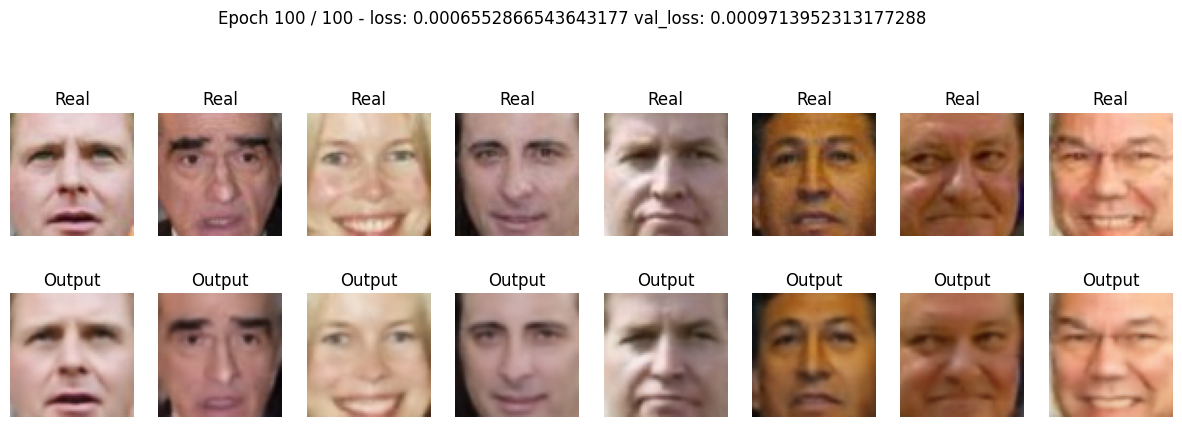

In [68]:
losses = train(autoencoder,optimizer, criterion, 100, train_loader, val_loader,scheduler)

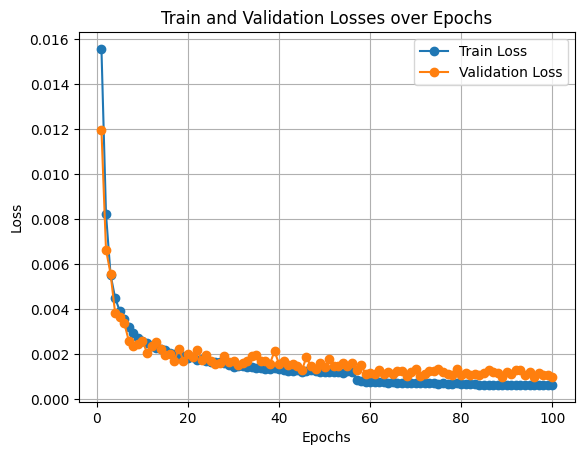

In [69]:
show_loss_plots(losses)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

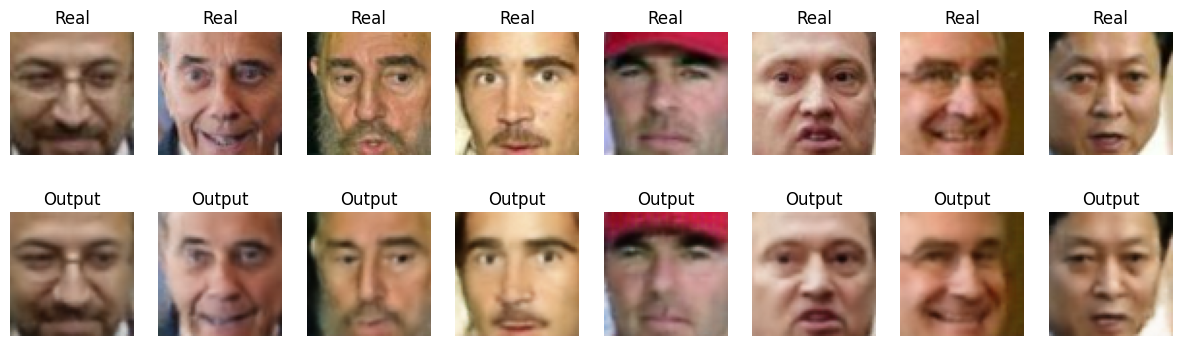

In [70]:
compare_reconstructed(autoencoder,val_loader)

Декодированные лица достаточно похожи на оригинал, значит модель работает

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

Попробуем сгенерировать лица из случайных латентных векторов

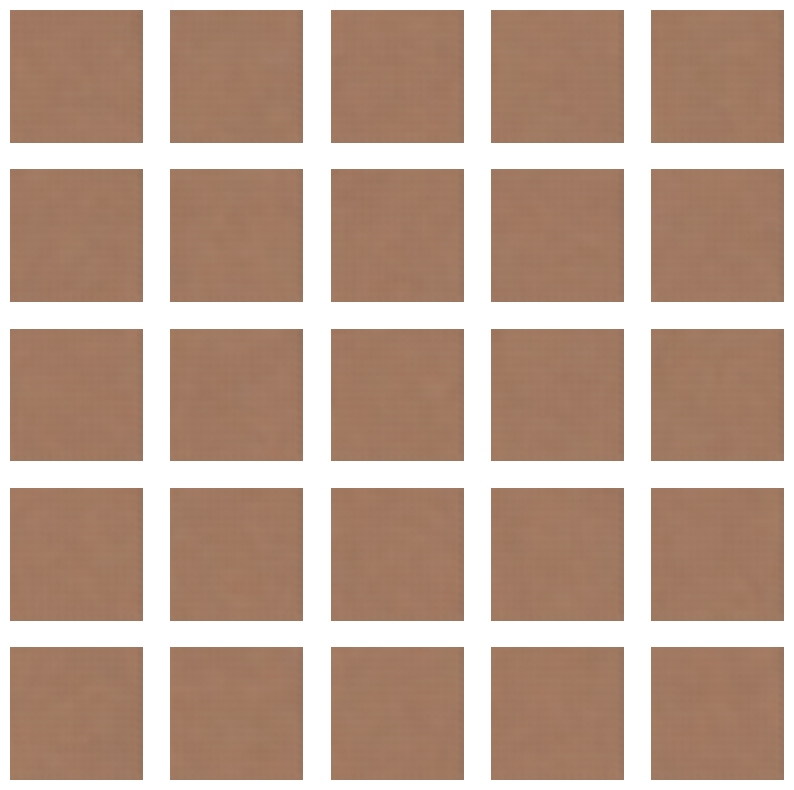

In [84]:
z = torch.randn((25,dim_code))
autoencoder.eval()
output = autoencoder.sample(z.to(device)).detach().cpu()
plt.figure(figsize=(10, 10))
clear_output(wait=True)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.rollaxis(output[i].numpy(), 0, 3), cmap='gray')
    plt.axis('off')
plt.show()

При случайной генерации вместо лиц получился просто однотонный фон. Поэтому возьмем среднее и дисперсию из тестовой выборки и сгенерируем случайны вектор с нормальным распределением с данными параметрами

In [78]:
latents = torch.Tensor()
autoencoder.eval()
for X_batch in train_loader:
    # with torch.no_grad():
    _, latent = autoencoder(X_batch.to(device))
    latents = torch.cat((latents, latent.detach().cpu()), dim=0)
mean = torch.mean(latents, dim=0)
std = torch.std(latents, dim=0)
print(f"Mean shape: {mean.shape=} Std shape: {std.shape=}")

Mean shape: mean.shape=torch.Size([512]) Std shape: std.shape=torch.Size([512])


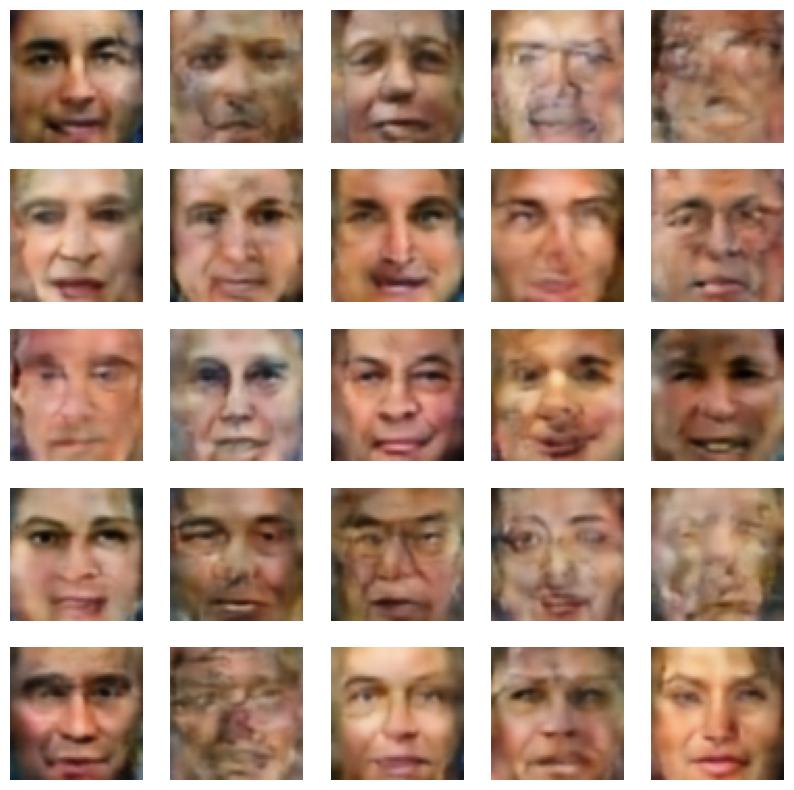

In [85]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.randn((25,dim_code)) * std + mean
autoencoder.eval()
output = autoencoder.sample(z.to(device)).detach().cpu()
plt.figure(figsize=(10, 10))
clear_output(wait=True)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.rollaxis(output[i].numpy(), 0, 3), cmap='gray')
    # plt.title('Generated')
    plt.axis('off')
plt.show()


Видно, что то, что сгенерировано - действительно лица. Конечно, качество оставляет желать лучшего, но главное, что работает. Ура!

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Функция получения индексов картинок с ярко-выраженными признаками

In [88]:
def get_feature_indices(feature: str, num_samples = 20, threshold: int = 1):
    max_indices = []
    min_indices = []
    with open("lfw_attributes.txt","r") as file: # считываем файл
        for i, line in enumerate(file):
            if i ==0: # комментарий
                continue
            if i == 1: # названия признаков
                description = {feature : j-1 for j, feature in enumerate(line.strip().split("\t"))}
                print(description)
                feature_index = description[feature]
                continue
            feature_value = float(line.strip().split("\t")[feature_index]) # получаем знаачение фичи
            # Если значение признака превышает порог - сохраняем индекс изображения
            if feature_value > threshold and len(max_indices) < num_samples:
                max_indices.append(i-2) # Т.к. первые 2 строки - комментарии и заголовок таблицы
            if feature_value < -threshold and len(min_indices) < num_samples:
                min_indices.append(i-2)
            if len(max_indices) == num_samples and len(min_indices) == num_samples:
                break
    return max_indices, min_indices

Получим индексы улыбающихся и грустных людей

In [89]:
smile_indices, sad_indices = get_feature_indices("Smiling")

{'#': -1, 'person': 0, 'imagenum': 1, 'Male': 2, 'Asian': 3, 'White': 4, 'Black': 5, 'Baby': 6, 'Child': 7, 'Youth': 8, 'Middle Aged': 9, 'Senior': 10, 'Black Hair': 11, 'Blond Hair': 12, 'Brown Hair': 13, 'Bald': 14, 'No Eyewear': 15, 'Eyeglasses': 16, 'Sunglasses': 17, 'Mustache': 18, 'Smiling': 19, 'Frowning': 20, 'Chubby': 21, 'Blurry': 22, 'Harsh Lighting': 23, 'Flash': 24, 'Soft Lighting': 25, 'Outdoor': 26, 'Curly Hair': 27, 'Wavy Hair': 28, 'Straight Hair': 29, 'Receding Hairline': 30, 'Bangs': 31, 'Sideburns': 32, 'Fully Visible Forehead': 33, 'Partially Visible Forehead': 34, 'Obstructed Forehead': 35, 'Bushy Eyebrows': 36, 'Arched Eyebrows': 37, 'Narrow Eyes': 38, 'Eyes Open': 39, 'Big Nose': 40, 'Pointy Nose': 41, 'Big Lips': 42, 'Mouth Closed': 43, 'Mouth Slightly Open': 44, 'Mouth Wide Open': 45, 'Teeth Not Visible': 46, 'No Beard': 47, 'Goatee': 48, 'Round Jaw': 49, 'Double Chin': 50, 'Wearing Hat': 51, 'Oval Face': 52, 'Square Face': 53, 'Round Face': 54, 'Color Photo':

Отрисуем сначала улыбающихся, а затем и грустных

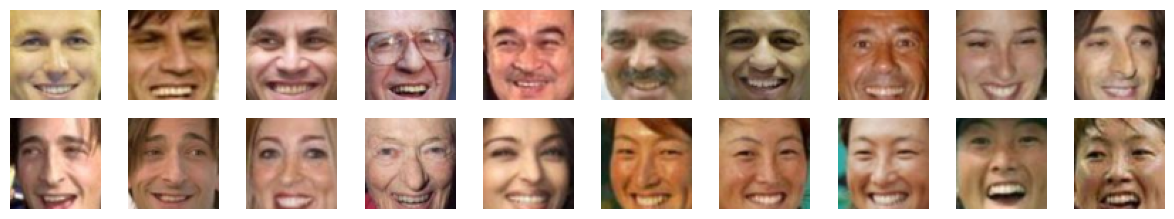

In [94]:
fig = plt.figure(figsize=(15, 4))
for i,index in enumerate(smile_indices):
    plt.subplot(3,10,i+1)
    plt.imshow(data[index])
    plt.axis("off")

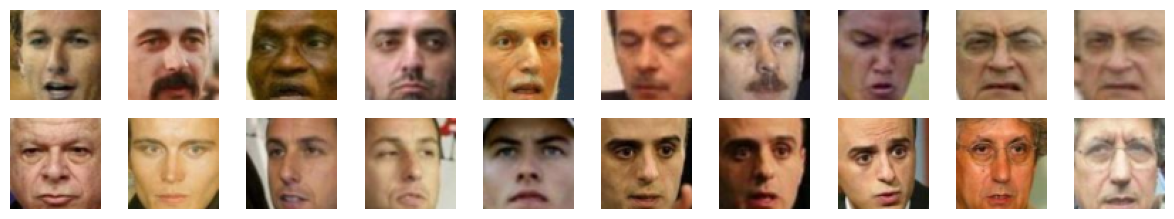

In [95]:
fig = plt.figure(figsize=(15, 4))
for i,index in enumerate(sad_indices):
    plt.subplot(3,10,i+1)
    plt.imshow(data[index])
    plt.axis("off")

Результат соответствует ожиданиям, картинки выбраны правильно.

Функция получения латентных векторов из картинок

In [96]:
def get_latent_vector(model,dataset):
    model.eval()
    latents = torch.Tensor()
    # for img in dataset:
    _, latent = model(dataset.to(device))
    latents = torch.cat((latents, latent.detach().cpu()), dim=0)
    return latents 

Получим латентные векторы улыбающихся и грустных людей

In [97]:
smile_data = torch.tensor(np.rollaxis(data[smile_indices], 3, 1)).float()
smile_latents = get_latent_vector(autoencoder, smile_data) 

sad_data = torch.tensor(np.rollaxis(data[sad_indices], 3, 1)).float()
sad_latents = get_latent_vector(autoencoder, sad_data)

Вычислим вектор улыбки

In [98]:
smile_vector = smile_latents.mean(dim=0) - sad_latents.mean(dim=0)

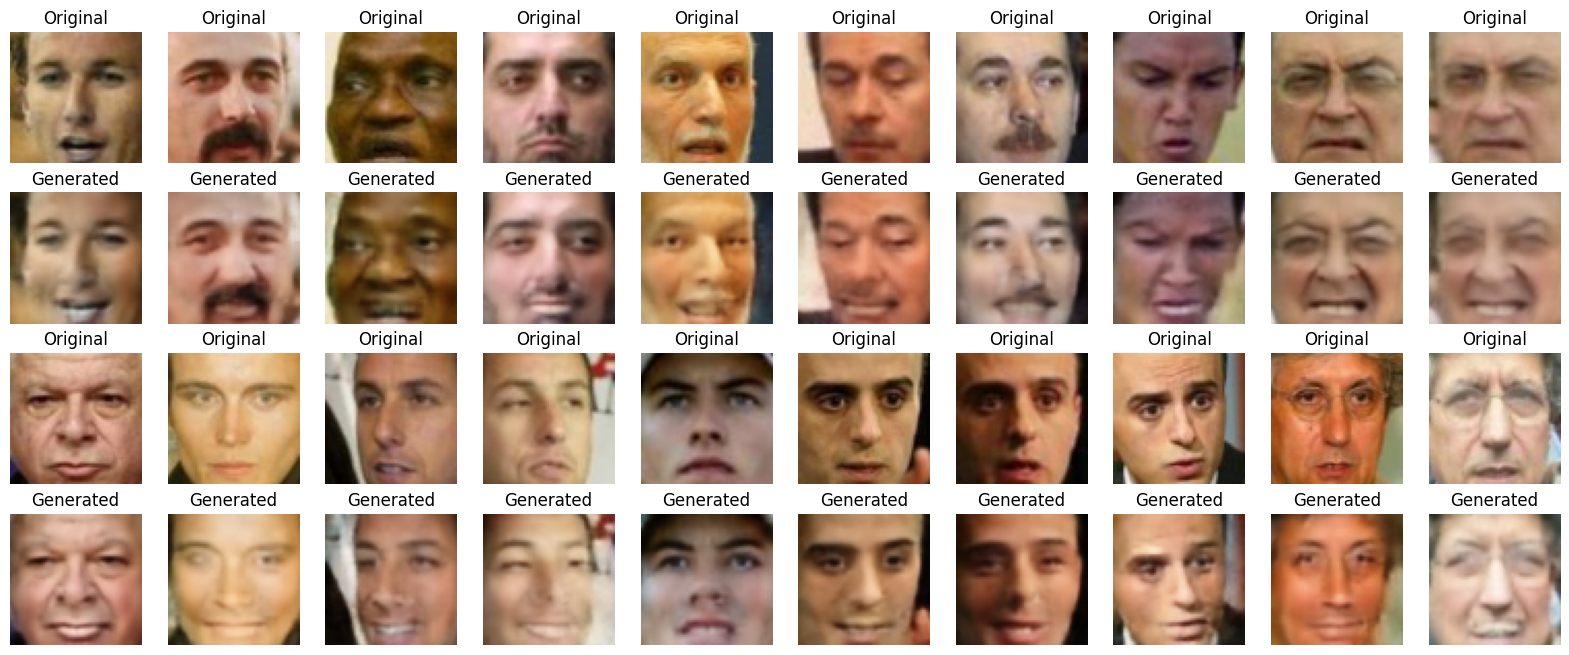

In [108]:
smiling_sad_latents = sad_latents + smile_vector
smiling_sad = autoencoder.sample(smiling_sad_latents.to(device)).detach().cpu()
fig = plt.figure(figsize=(20, 8))
for i in range(len(sad_indices)):
    pos = i + 1 if i < 10 else i + 11
    plt.subplot(4,10,pos)
    plt.title("Original")
    plt.imshow(np.rollaxis(sad_data[i].numpy(), 0, 3), cmap='gray')
    plt.axis("off") 

    plt.subplot(4,10,pos + 10)
    plt.title("Generated")
    plt.imshow(np.rollaxis(smiling_sad[i].numpy(), 0, 3), cmap='gray')
    plt.axis("off")
    



Видно, что преобразование сработало.
Какие счастливые и довольные лица, не то, что раньше! Местами кажется, что мы вычислили не вектор улыбки, а вектор зубов, но главное, что  работает :) 

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [109]:
batch_size = 32
from torchvision import transforms
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

В данной части попробуем реализовать линейный автоэнкодер, а не сверточный, для разнообразия

In [110]:
dim_code = 32

class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,dim_code*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, out_features=512),
            nn.Linear(512,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048,512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 28*28)
        )

    def encode(self, x):
        x= self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, dim_code)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) 
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample    
        return mu

    def decode(self, z):
        smooth = 1e-7
        x = self.decoder(z)
        x = x.view(-1, 1, 28, 28)
        x = torch.sigmoid(x)
        x = torch.clamp(x,smooth, 1 - smooth)
        reconstruction = x.view(-1, 1, 28, 28)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu,logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Также ради интереса сравнивал работу линейного и сверточного vae, если интересно - можно запустить и посмотреть, он тоже работает. Однако далее будет рассматриваться только линейный

In [19]:
dim_code = 16
start_features = 32

class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, start_features, 3, padding=1),
            nn.BatchNorm2d(start_features),
            nn.MaxPool2d(2,2), # 28 -> 14
            nn.LeakyReLU(),
            nn.Conv2d(start_features, start_features * 2, 3, padding=1),
            nn.BatchNorm2d(start_features * 2),
            nn.MaxPool2d(2,2), # 14 -> 7
            nn.LeakyReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(start_features * 2 * 7*7, dim_code * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, start_features * 2 * 7*7),
            nn.Unflatten(1,(start_features * 2,7,7)),
            nn.ConvTranspose2d(start_features * 2, start_features, 3, stride=2, padding=1, output_padding=1), # 7 -> 14
            nn.BatchNorm2d(start_features),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(start_features, 1, 3, stride=2, padding=1, output_padding=1), # 14 -> 28
        )
    


    def encode(self, x):
        x = self.encoder(x)
        mu, logsigma = torch.split(x, dim_code, dim=1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) 
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        return mu

    def decode(self, z):
        smooth = 1e-7
        x = self.decoder(z)
        x = torch.sigmoid(x)
        x = torch.clamp(x,smooth, 1 - smooth)
        reconstruction = x.view(-1, 1, 28, 28)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu,logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [111]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = - 0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp()) / mu.shape[0]
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x) / x.shape[0]

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [123]:
criterion = loss_vae

vae = VAE().to(device)

vae_optimizer = optim.AdamW(vae.parameters(),10e-4)

In [124]:
def train_vae(model, opt, loss_fn, epochs, train_loader, val_loader, scheduler = None, visible = True):
    # Инициализация лоссов и метрик
    losses = {"train" : [], "val" : []}

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, _ in train_loader:
            mu, logsigma, reconstruction = model(X_batch.to(device))
            
            loss =  loss_fn(X_batch.to(device), mu, logsigma, reconstruction)
            loss.backward()
            opt.step()
            opt.zero_grad()
            avg_loss += loss / len(train_loader)
        losses["train"].append(avg_loss.detach().cpu())
        # show intermediate results
        model.eval()  # testing mode
        X_val, _ = next(iter(val_loader))
        val_mu, val_logsigma, val_reconstruction = model(X_val.to(device))
        val_loss = loss_fn(X_val.to(device), val_mu, val_logsigma, val_reconstruction).detach().cpu()
        losses["val"].append(val_loss)
        if scheduler is not None:
            scheduler.step(val_loss)
        
        X_val = X_val.detach().cpu()
        val_reconstruction = val_reconstruction.detach().cpu()
   
        print('loss: %f' % avg_loss)
        # Visualize tools
        if visible:
            plt.figure(figsize=(15, 9))
            clear_output(wait=True)
            for i in range(8):
                plt.subplot(4, 8, i+1)
                plt.imshow(np.rollaxis(X_val[i].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')
                
                plt.subplot(4, 8, i+9)
                plt.imshow(np.rollaxis(val_reconstruction[i].detach().cpu().numpy(), 0, 3), cmap='gray')
                plt.title('Output')
                plt.axis('off')

            # Тут выводим в тайтле промежуточные значения и лоссы, чтобы наблюдать за ними в процессе обучения
            plt.suptitle(f'Epoch {epoch+1} / {epochs} - train_loss: {avg_loss} val_loss: {val_loss}')
            plt.show()
    return losses

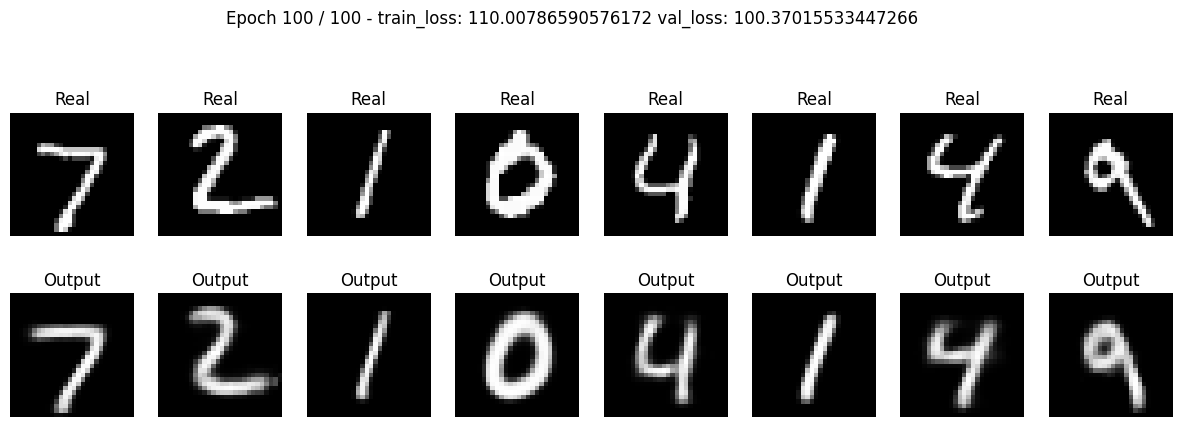

In [125]:
# <обучите модель на датасете MNIST>
vae_losses = train_vae(vae,vae_optimizer,loss_vae,100,train_loader, test_loader)

Посмотрим на график лоссов

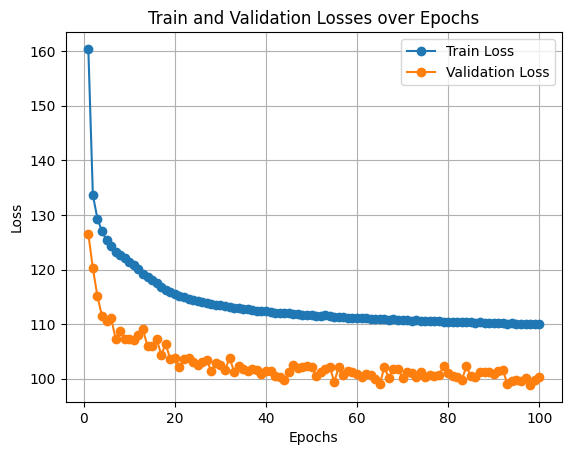

In [126]:
show_loss_plots(vae_losses)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [127]:
def compare_reconstructed(model, val_loader):
    X_val, _ = next(iter(val_loader))
    mu, logsigma, reconstruction = model(X_val.to(device))
    mu, logsigma, reconstruction = mu.detach().cpu(), logsigma.detach().cpu(), reconstruction.detach().cpu()
    plt.figure(figsize=(15, 9))
    for i in range(8):
        plt.subplot(4, 8, i+1)
        plt.imshow(np.rollaxis(X_val[i].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')
        
        plt.subplot(4, 8, i+9)
        plt.imshow(np.rollaxis(reconstruction[i].numpy(), 0, 3), cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

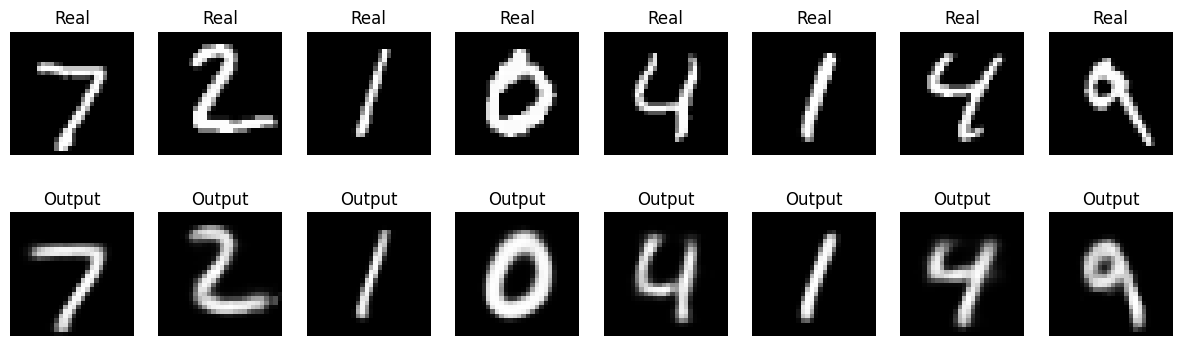

In [128]:
compare_reconstructed(vae, test_loader)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

/tmp/ipykernel_1271020/1778061355.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = vae.decode(torch.tensor(z).float().to(device))


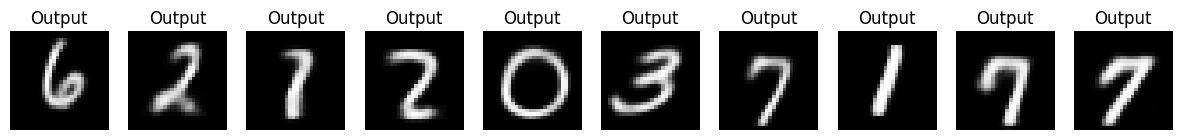

In [130]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = torch.randn((10,32))
vae.eval()
output = vae.decode(torch.tensor(z).float().to(device))
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(4, 10, i+1)
    plt.imshow(np.rollaxis(output[i].detach().cpu().numpy(), 0, 3), cmap='gray')
    plt.title('Output')
    plt.axis('off')
plt.show()

В целом, все сгенерированные изображения похожи на цифры, однако попробуем добавить среднее и std с тестовой выборки

In [131]:
latents_mu = torch.Tensor()
vae.eval()
for X_batch, _ in train_loader:
    mu, _ = vae.encode(X_batch.to(device))
    latents_mu = torch.cat((latents_mu, mu.detach().cpu()), dim=0)
mean_mu = torch.mean(latents_mu, dim=0)

Теперь попробуем ещё раз, но уже со средним и std

/tmp/ipykernel_1271020/1599838075.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = vae.decode(torch.tensor(z).float().to(device))


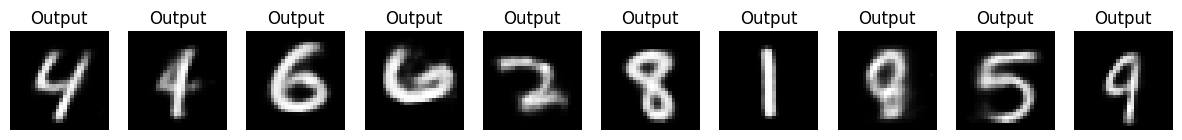

In [133]:
z = torch.randn((10,32)) + mean_mu
vae.eval()
output = vae.decode(torch.tensor(z).float().to(device))
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(4, 10, i+1)
    plt.imshow(np.rollaxis(output[i].detach().cpu().numpy(), 0, 3), cmap='gray')
    plt.title('Output')
    plt.axis('off')
plt.show()

Выгляди примерно также, сложно сказать, что стало лучше

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

Кажется тут опечатка, т.к. сначала просят вывести латентные векторы лиц, а затем речь идет уже о цифрах. Т.к. это задание из второй части, то предположу, что нужно работать именно с цифрами

Получим латентные представления

In [134]:

latents_mu = torch.Tensor()
labels = torch.Tensor()
vae.eval()
for X_batch, label in train_loader:
    mu, _ = vae.encode(X_batch.to(device))
    latents_mu = torch.cat((latents_mu, mu.detach().cpu()), dim=0)
    labels = torch.cat((labels,label), dim=0)
latents_mu = latents_mu[1:]
labels = labels[1:]


Сожмем представления с помощью TSNE

In [135]:
from sklearn.manifold import TSNE


vae_tsne = TSNE(n_components=2).fit_transform(latents_mu)

Отрисуем полученные представления 

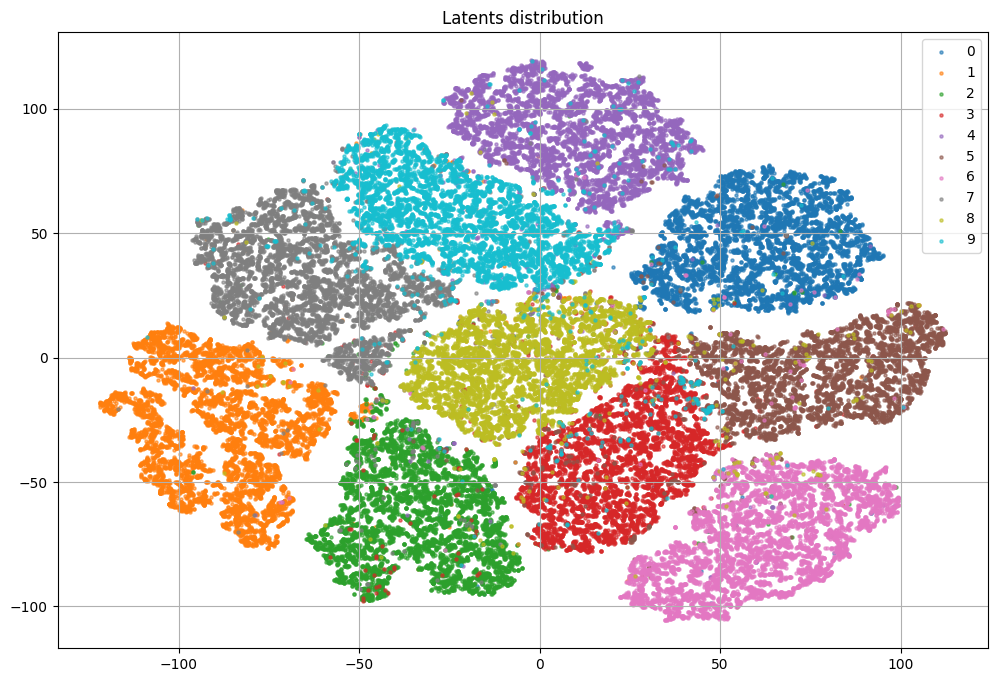

In [136]:
plt.figure(figsize=(12, 8))
unique_labels = torch.unique(labels)
colors = plt.cm.tab10(torch.linspace(0, 1, len(unique_labels)))
for label, color in zip(unique_labels, colors):
    # Выбор точек для текущей метки
    mask = labels == label
    # indices = torch.where(labels == label)
    x = vae_tsne[mask,0]
    y = vae_tsne[mask,1]
    
    # Отрисовка scatter plot для текущей метки с соответствующим цветом
    plt.scatter(x, y, label=int(label.item()), color=color, alpha=0.6, s=5)

plt.title('Latents distribution')
plt.legend()
plt.grid(True)
plt.show()

Что вы думаете о виде латентного представления?

Видно, что латентные представления классов расположены группами. При этом схожие по форме цифры расположены рядом, например 1(оранжевый) и 7 (серый), или 6(розовый) и 5(коричневый), а различные, напротив, ужалены друг от друга, например 0 и 1, или 6 и 7. Также видно, что 9-ка(бирюзовый) похожа на многие цифры и её экземпляры попадают в другие кластеры. Всё сходится с тем, о чем говорилось в семинаре.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

Немного доработает линейный VAE из прошлого пункта, чтобы он стал Conditional

In [17]:
dim_code = 32
num_classes = 10
class CVAE(nn.Module):
    def __init__(self):

        super(CVAE,self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(num_classes + 28*28,2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,dim_code*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code + num_classes, out_features=512),
            nn.Linear(512,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048,512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 28*28)
        )

    def encode(self, x, class_num):
        x= torch.cat([self.flatten(x).float(), F.one_hot(torch.tensor(class_num),num_classes)], dim=1)
        x = self.encoder(x)
        mu, logsigma = torch.split(x,32,dim=1)
        return mu, logsigma, class_num


    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) 
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        return mu

    def decode(self, z, class_num):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        smooth = 1e-7
        x = self.decoder(torch.cat([z, F.one_hot(torch.Tensor(class_num),num_classes)], dim=1))
        x = torch.sigmoid(x)
        x = torch.clamp(x,smooth, 1 - smooth)
        reconstruction = x.view(-1, 1, 28, 28)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu,logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [138]:
criterion = loss_vae

cvae = CVAE().to(device)

cvae_optimizer = optim.AdamW(cvae.parameters(),10e-4)

In [137]:
def train_cvae(model, opt, loss_fn, epochs, train_loader, val_loader, scheduler = None, visible = True):
    # Инициализация лоссов и метрик
    losses = {"train" : [], "val" : []}

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, class_num in train_loader:
            mu, logsigma, reconstruction = model(X_batch.to(device), class_num.to(device))
        
            loss =  loss_fn(X_batch.to(device), mu, logsigma, reconstruction)
            loss.backward()
            opt.step()
            opt.zero_grad()
            avg_loss += loss / len(train_loader)
        losses["train"].append(avg_loss.detach().cpu())
        # show intermediate results
        model.eval()  # testing mode
        X_val, class_num = next(iter(val_loader))
        val_mu, val_logsigma, val_reconstruction = model(X_val.to(device), class_num.to(device))
        val_loss = loss_fn(X_val.to(device), val_mu, val_logsigma, val_reconstruction).detach().cpu()
        losses["val"].append(val_loss)
        if scheduler is not None:
            scheduler.step(val_loss)
        
        X_val = X_val.detach().cpu()
        val_reconstruction = val_reconstruction.detach().cpu()
   
        print('loss: %f' % avg_loss)
        # Visualize tools
        if visible:
            plt.figure(figsize=(15, 9))
            clear_output(wait=True)
            for i in range(8):
                plt.subplot(4, 8, i+1)
                plt.imshow(np.rollaxis(X_val[i].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')
                
                plt.subplot(4, 8, i+9)
                plt.imshow(np.rollaxis(val_reconstruction[i].detach().cpu().numpy(), 0, 3), cmap='gray')
                plt.title('Output')
                plt.axis('off')

            # Тут выводим в тайтле промежуточные значения и лоссы, чтобы наблюдать за ними в процессе обучения
            plt.suptitle(f'Epoch {epoch+1} / {epochs} - train_loss: {avg_loss} val_loss: {val_loss}')
            plt.show()
    return losses

In [9]:
def train_cvae(model, opt, loss_fn, epochs, train_loader, val_loader, scheduler = None, visible = True):
    # Инициализация лоссов и метрик
    losses = {"train" : [], "val" : []}

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, class_num in train_loader:
            mu, logsigma, reconstruction = model(X_batch.to(device), class_num.to(device))
            loss =  loss_fn(X_batch.to(device), mu, logsigma, reconstruction)
            loss.backward()
            opt.step()
            opt.zero_grad()
            avg_loss += loss / len(train_loader)
            
            
        losses["train"].append(avg_loss.detach().cpu())
        print('loss: %f' % avg_loss)
        if visible:
            plt.figure(figsize=(15, 9))
            clear_output(wait=True)
            for i in range(8):
                plt.subplot(4, 8, i+1)
                plt.imshow(np.rollaxis(X_batch[i].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')
                
                plt.subplot(4, 8, i+9)
                plt.imshow(np.rollaxis(reconstruction[i].detach().cpu().numpy(), 0, 3), cmap='gray')
                plt.title('Output')
                plt.axis('off')

            # Тут выводим в тайтле промежуточные значения и лоссы, чтобы наблюдать за ними в процессе обучения
            plt.suptitle(f'Epoch {epoch+1} / {epochs} - loss: {avg_loss} ')
            plt.show()
    return losses

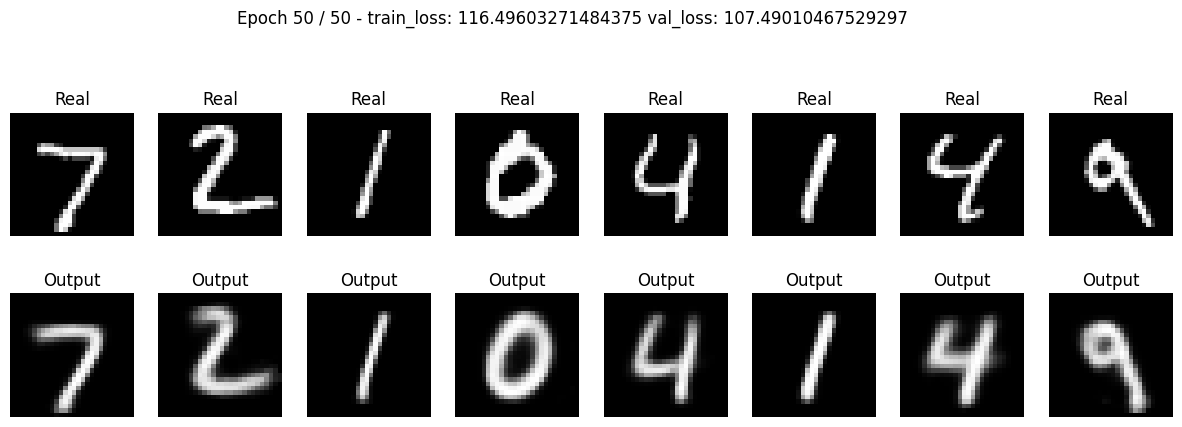

In [140]:
cvae_losses = train_cvae(cvae,cvae_optimizer,loss_vae, 50, train_loader, test_loader)

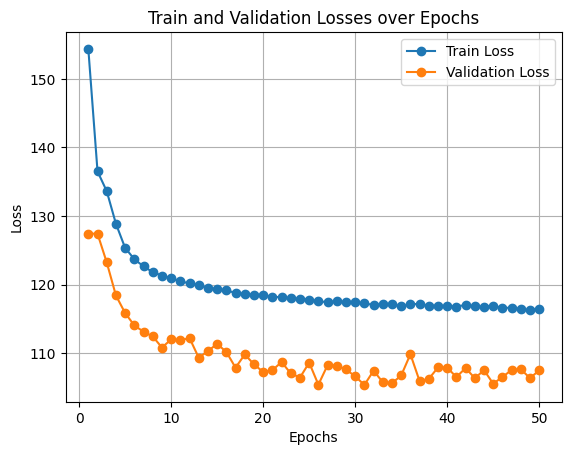

In [141]:
show_loss_plots(cvae_losses)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

/tmp/ipykernel_1271020/1980190773.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = cvae.decode(torch.tensor(z).float().to(device), classes.to(device))


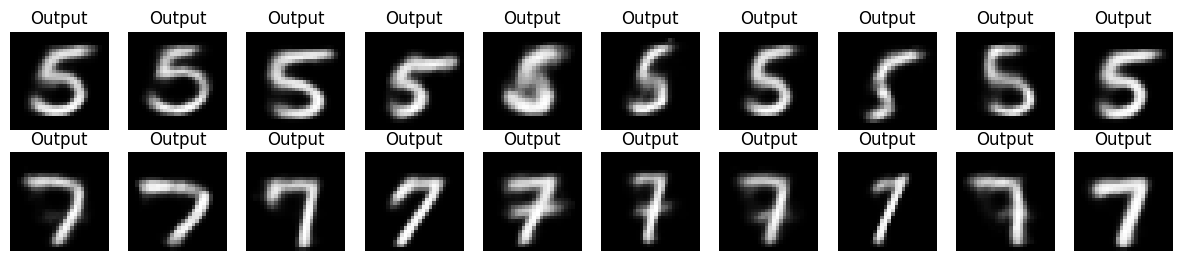

In [142]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
z = torch.randn((10,32)) # генерируем латентые векторы
z = torch.cat((z,z),dim=0) # дублируем, т.к. хотим проверить каждый из векторов на 2-ух цифрах
classes = torch.cat((torch.tensor([5]*10), torch.tensor([7]*10)),dim=0) # создаем тензоры классов 5 и 7
cvae.eval()
output = cvae.decode(torch.tensor(z).float().to(device), classes.to(device))
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(4, 10, i+1)
    plt.imshow(np.rollaxis(output[i].detach().cpu().numpy(), 0, 3), cmap='gray')
    plt.title('Output')
    plt.axis('off')
plt.show()

Сгенерированные 5-ки и 7-ки выглядят достаточно хорошо, сэмплинг работает и без добавления среднего и std поэтому опустим этот шаг

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [143]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
latents_mu = torch.Tensor()
labels = torch.Tensor()
cvae.eval()
for X_batch, label in train_loader:
    mu, _, class_num = cvae.encode(X_batch.to(device),label.to(device))
    latents_mu = torch.cat((latents_mu, mu.detach().cpu()), dim=0)
    labels = torch.cat((labels,label), dim=0)
latents_mu = latents_mu[1:]
labels = labels[1:]

/tmp/ipykernel_1271020/2860613919.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x= torch.cat([self.flatten(x).float(), F.one_hot(torch.tensor(class_num),num_classes)], dim=1)


In [144]:
from sklearn.manifold import TSNE

cvae_tsne = TSNE(n_components=2).fit_transform(latents_mu)

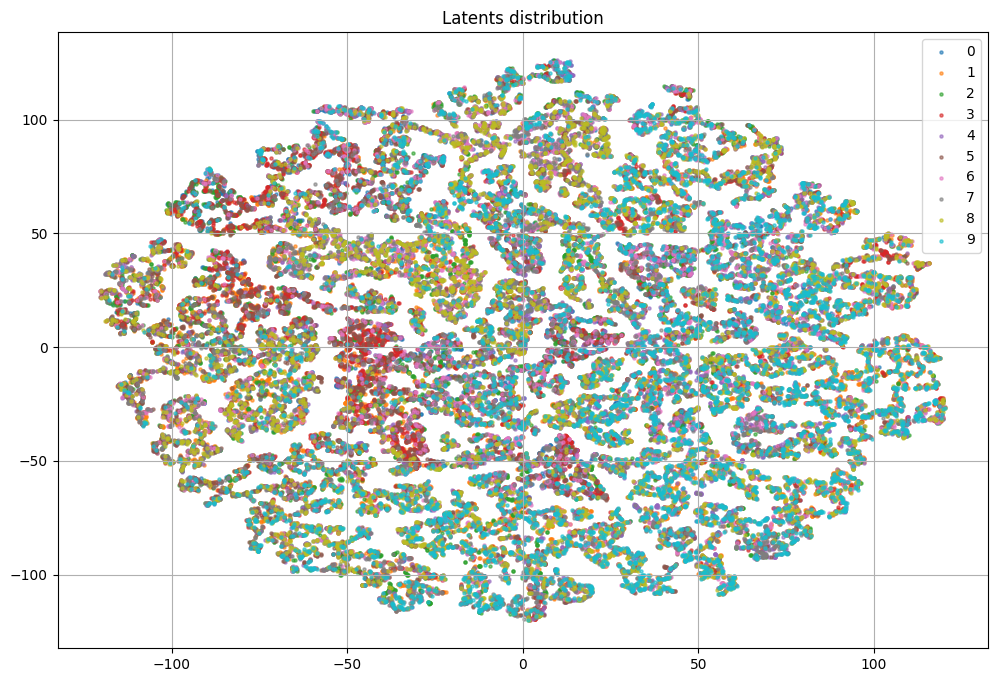

In [54]:
plt.figure(figsize=(12, 8))
unique_labels = torch.unique(labels)
colors = plt.cm.tab10(torch.linspace(0, 1, len(unique_labels)))
for label, color in zip(unique_labels, colors):
    # Выбор точек для текущей метки
    mask = labels == label
    x = cvae_tsne[mask,0]
    y = cvae_tsne[mask,1]
    
    # Отрисовка scatter plot для текущей метки с соответствующим цветом
    plt.scatter(x, y, label=int(label.item()), color=color, alpha=0.6, s=5)

plt.title('Latents distribution')
plt.legend()
plt.grid(True)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Представление CVAE разительно отличается от представления VAE, здесь нет ярко-выраженных групп и классы распределны более равномерно в пространстве. Что, впрочем, никак не мешает модели выдавать хорошее качество сэмплов.

В целом, очень интересное домашнее задание. Модели можно было обучать меньшее количество эпох(50-ти хватило бы), также возможно стоило бы попытаться уменьшить размер латентного вектора для AE, а также поиграться с параметрами, чтобы улучшить результат генерации лиц, но вроде и так всё сработало неплохо.

Бонусы сделаю позднее, для себя, пока что нет времени, поэтому дальше можно не проверять

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>